* Import main Library

In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim

* Show Time Data Using Cos

In [2]:
# Generate synthetic time series data with complex seasonality
np.random.seed(42)
data_length = 500
time = np.arange(0, data_length)
seasonal_component_1 = 10 * np.cos(2 * np.pi * time / 50)  # Frequency 1
seasonal_component_2 = 5 * np.cos(2 * np.pi * time / 30)   # Frequency 2
seasonal_component_3 = 3 * np.cos(2 * np.pi * time / 80)   # Frequency 3
noise = np.random.normal(0, 2, size=data_length)           # Random noise
data = seasonal_component_1 + seasonal_component_2 + seasonal_component_3 + noise

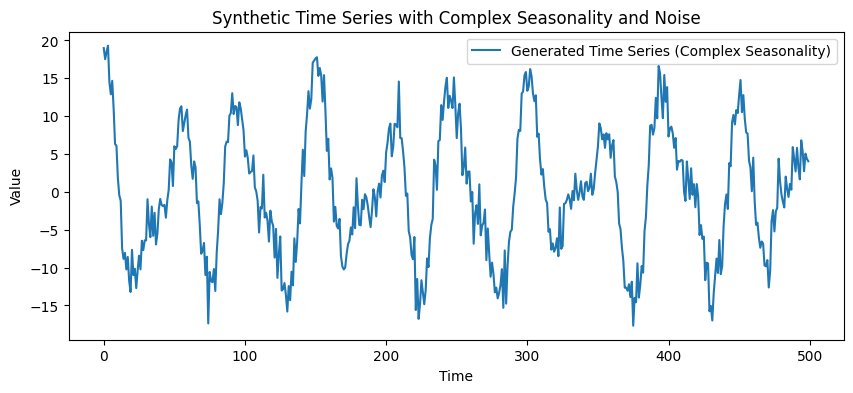

In [3]:
# Plot the generated dataset
plt.figure(figsize=(10, 4))
plt.plot(time, data, label="Generated Time Series (Complex Seasonality)")
plt.title("Synthetic Time Series with Complex Seasonality and Noise")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

* `Set X, Y`

In [4]:

# Scaling the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Function to create dataset for LSTM
def create_dataset(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])  # Predict next time step
    return np.array(x), np.array(y)

# Sequence length
seq_length = 50

# Create input/output sequences
x, y = create_dataset(data_scaled, seq_length)

* `Select Devise --> Cuda, Cpu, mps`

In [5]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


* `Splitting Into Training & Testing`

In [6]:
# Split the data into training, validation, and testing sets
train_size = int(len(x) * 0.7)
val_size = int(len(x) * 0.2)
test_size = len(x) - train_size - val_size

x_train, x_val, x_test = x[:train_size], x[train_size:train_size + val_size], x[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Convert the data into PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

## Create LSTM Model

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, fc_layers=[128, 64], dropout=0.5):
        super(LSTMModel, self).__init__()
        
        # Create LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Create Fully connected layers
        fc_layers = [hidden_size] + fc_layers
        self.fc_layers = nn.ModuleList(
            [nn.Linear(fc_layers[i], fc_layers[i+1]) for i in range(len(fc_layers)-1)]
        )
        self.fc_out = nn.Linear(fc_layers[-1], output_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the output from the last time step
        
        # Pass through fully connected layers
        for fc in self.fc_layers:
            out = self.activation(fc(out))
            out = self.dropout(out)
        
        out = self.fc_out(out)
        return out

# Define model parameters
input_size = 1
hidden_size = 64
output_size = 1
num_layers = 2
fc_layers = [128, 64]
dropout = 0.5

# Instantiate the model
model = LSTMModel(input_size, hidden_size, output_size, num_layers, fc_layers, dropout).to(device)

# Print the model structure
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
)


* `Training Model`

In [8]:
# Define RMSE computation
def compute_rmse(predictions, targets):
    return torch.sqrt(nn.functional.mse_loss(predictions, targets))

# Training parameters
criterion = nn.MSELoss()  # MSE loss for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 500

# Store metrics
train_losses, val_losses = [], []
train_r2_scores, val_r2_scores = [], []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    
    # Forward pass on training data
    outputs = model(x_train)
    train_loss = criterion(outputs, y_train)
    train_rmse = compute_rmse(outputs, y_train)
    
    # Calculate R² for training
    train_r2 = r2_score(y_train.cpu().numpy(), outputs.detach().cpu().numpy())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Save training metrics
    train_losses.append(train_loss.item())
    train_r2_scores.append(train_r2)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        val_rmse = compute_rmse(val_outputs, y_val)

        # Calculate R² for validation
        val_r2 = r2_score(y_val.cpu().numpy(), val_outputs.detach().cpu().numpy())

        val_losses.append(val_loss.item())
        val_r2_scores.append(val_r2)

    # Logging progress every 10 epochs
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {train_loss.item():.4f}, Train RMSE: {train_rmse.item():.4f}, Train R²: {train_r2:.4f} | "
            f"Val Loss: {val_loss.item():.4f}, Val RMSE: {val_rmse.item():.4f}, Val R²: {val_r2:.4f}"
        )

Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500] | Train Loss: 0.2839, Train RMSE: 0.5328, Train R²: -4.7671 | Val Loss: 0.2602, Val RMSE: 0.5101, Val R²: -2.9454
Epoch [11/500] | Train Loss: 0.1167, Train RMSE: 0.3417, Train R²: -1.3714 | Val Loss: 0.0932, Val RMSE: 0.3053, Val R²: -0.4139
Epoch [21/500] | Train Loss: 0.0629, Train RMSE: 0.2508, Train R²: -0.2773 | Val Loss: 0.0633, Val RMSE: 0.2517, Val R²: 0.0395
Epoch [31/500] | Train Loss: 0.0611, Train RMSE: 0.2473, Train R²: -0.2420 | Val Loss: 0.0635, Val RMSE: 0.2519, Val R²: 0.0376
Epoch [41/500] | Train Loss: 0.0628, Train RMSE: 0.2505, Train R²: -0.2752 | Val Loss: 0.0600, Val RMSE: 0.2450, Val R²: 0.0896
Epoch [51/500] | Train Loss: 0.0598, Train RMSE: 0.2444, Train R²: -0.2138 | Val Loss: 0.0579, Val RMSE: 0.2405, Val R²: 0.1226
Epoch [61/500] | Train Loss: 0.0481, Train RMSE: 0.2193, Train R²: 0.0229 | Val Loss: 0.0512, Val RMSE: 0.2262, Val R²: 0.2243
Epoch [71/500] | Train Loss: 0.0438, Train RMSE: 0.2094, Train R²: 0.1096 | Val Loss: 0.0404, Val RMSE: 

* `Visulize Loss & ACcuracy Graph`

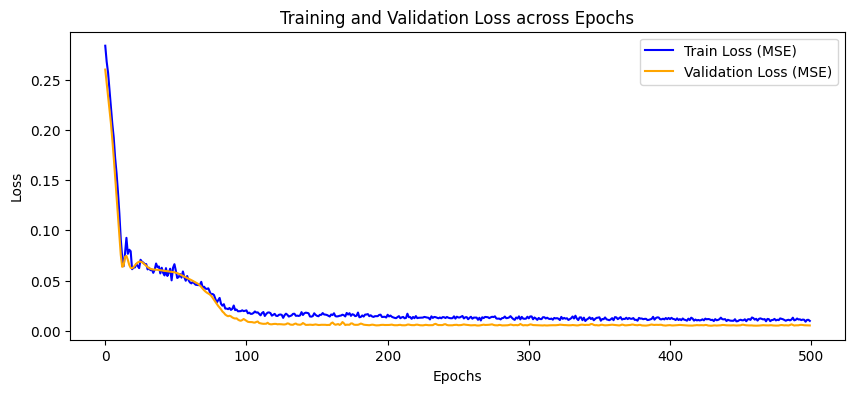

In [9]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss (MSE)', color='blue')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss (MSE)', color='orange')
plt.title('Training and Validation Loss across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

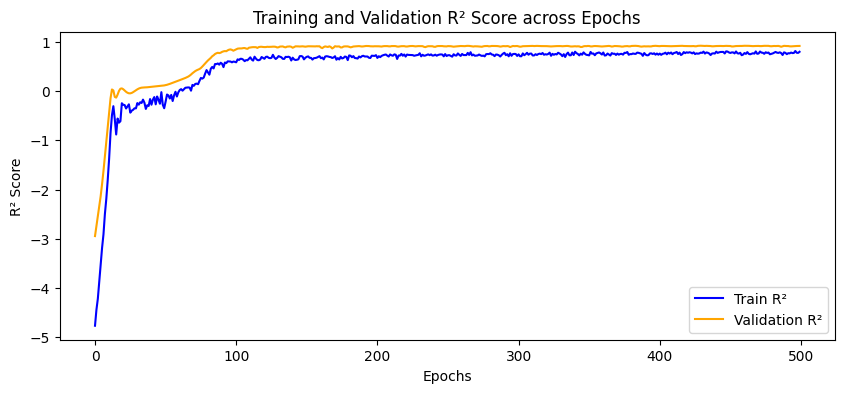

In [10]:
# Plot R² scores for training and validation
plt.figure(figsize=(10, 4))
plt.plot(range(len(train_r2_scores)), train_r2_scores, label='Train R²', color='blue')
plt.plot(range(len(val_r2_scores)), val_r2_scores, label='Validation R²', color='orange')
plt.title('Training and Validation R² Score across Epochs')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.show()

* `Testing`

In [11]:
# Test the model and inverse transform the predictions
model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    test_outputs = test_outputs.detach().cpu().numpy()  # Move to CPU after prediction
    test_outputs = scaler.inverse_transform(test_outputs)

# Inverse transform the actual values
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

# Flatten both arrays to ensure they are one-dimensional
y_test_actual = y_test_actual.flatten()
test_outputs = test_outputs.flatten()

# Ensure the length of both actual and predicted values is the same
assert len(y_test_actual) == len(test_outputs), f"Length mismatch: {len(y_test_actual)} vs {len(test_outputs)}"

# Calculate R² on test set
test_r2 = r2_score(y_test_actual, test_outputs)
print(f"R² Score on Test Set: {test_r2:.4f}")

# Calculate RMSE (Root Mean Squared Error) on Test Set
rmse = np.sqrt(mean_squared_error(y_test_actual, test_outputs))
print(f"RMSE on Test Set: {rmse:.4f}")

R² Score on Test Set: 0.7137
RMSE on Test Set: 2.8342


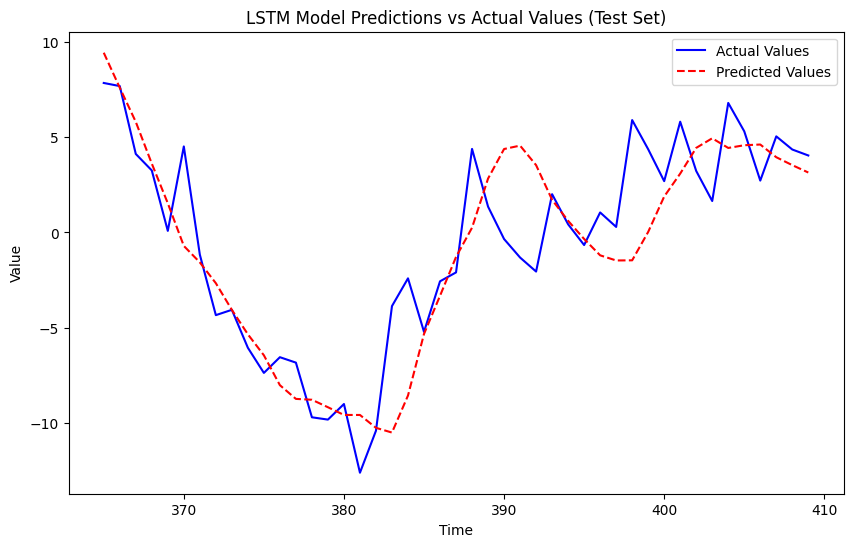

In [13]:
# Ensure the time axis matches the length of the test data (45 time steps)
time_test = time[train_size + seq_length:train_size + seq_length + len(test_outputs)]  # Adjust time for test set

# Plot predictions vs actual values on the test set
plt.figure(figsize=(10, 6))
plt.plot(time_test, y_test_actual, label="Actual Values", color='blue')
plt.plot(time_test, test_outputs, label="Predicted Values", color='red', linestyle='--')
plt.title('LSTM Model Predictions vs Actual Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
